In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import special
from scipy.spatial import distance

In [2]:
df = pd.read_csv('final_dataset.csv')
df.head()

,subreddit,subscribers,current_users,creation_date,date_accessed,time_accessed_UTC,appearances
0,changemyview,1349762,1272,2013-01-16,2021-09-19,20:28:04,8
1,Terraform,19623,38,2012-06-05,2021-09-19,20:28:05,5
2,lostpause,78056,255,2015-04-07,2021-09-19,20:28:06,5
3,USPS,69497,568,2009-07-12,2021-09-19,20:28:07,4
4,MaliciousCompliance,1664837,5484,2016-01-04,2021-09-19,20:28:08,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3678 entries, 0 to 3677
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subreddit          3678 non-null   object
 1   subscribers        3678 non-null   int64 
 2   current_users      3678 non-null   int64 
 3   creation_date      3678 non-null   object
 4   date_accessed      3678 non-null   object
 5   time_accessed_UTC  3678 non-null   object
 6   appearances        3678 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 201.3+ KB


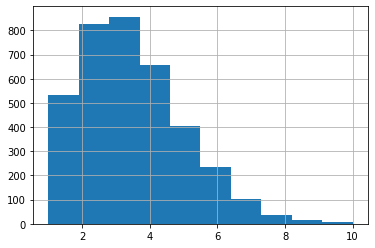

In [4]:
# looks vaguely poisson
df['appearances'].hist()
plt.show()

In [5]:
# poisson should have mean  == variance
m = np.mean(df['appearances'])
v = np.var(df['appearances'])
print('mean:    ', m)
print('variance:', v)

# not super far apart
# Idk what counts as far or not

mean:     3.2775965198477435
variance: 2.868834680053102


In [6]:
# Poisson dispersion test
# according to
# https://www.itl.nist.gov/div898/software/dataplot/refman1/auxillar/poisdisp.htm
# d = sum( (x_i - x_mean)**2 / x_mean )
x = df['appearances'].to_numpy()
d = np.sum( (x-np.mean(x))**2 / np.mean(x) )
print('Poisson Dispersion (according to one formula I found): ', d)
# Still can't find how to interpret that anywhere
# maybe this thing
# https://www.stat.berkeley.edu/~stark/Seminars/ssa12.pdf
# talks about chi-square goodness of fit
# I should read back up on that
# I don't really remember it

Poisson Dispersion (according to one formula I found):  3219.3022812111158


In [26]:
# https://stats.stackexchange.com/questions/328803/python-test-if-my-data-follow-a-poisson-exponential-distribution

# Take 3678 samples from a Poisson
# see how different that distribution is from my distribution

# mean of my distribution
# 3.28

# variance of my distribution
# 2.87

rng = np.random.default_rng()
N = 3678

my_mean_poisson = rng.poisson(lam=np.mean(x), size=N)
my_var_poisson = rng.poisson(lam=np.var(x), size=N)

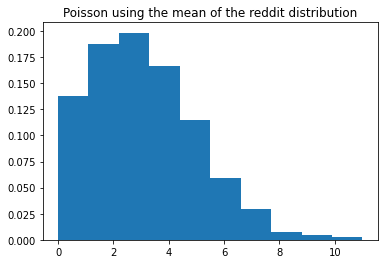

In [44]:
mean_counts, bins, patchs = plt.hist(my_mean_poisson, density=True)
plt.title("Poisson using the mean of the reddit distribution")
plt.show()

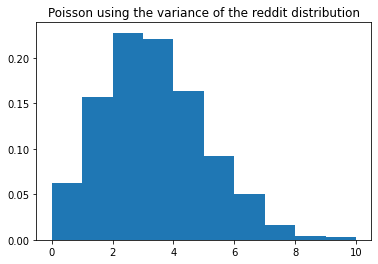

In [45]:
var_counts, bins, patches = plt.hist(my_var_poisson, density=True)
plt.title("Poisson using the variance of the reddit distribution")
plt.show()

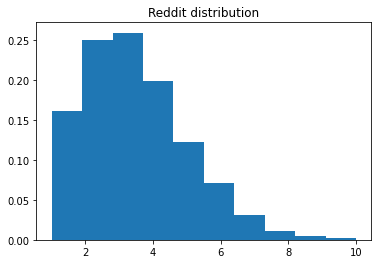

In [46]:
reddit_counts, bins, patches = plt.hist(x, density=True)
plt.title("Reddit distribution")
plt.show()

In [54]:
# Just looks too different I think
# But maybe it's just weird b/c there aren't any 0's
# I can't really have a 0 in my data
# Well I do, but "0" is just every subreddit other than the 3k that came up
# But we can do some statitical tests I suppose

# KL divergence
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.rel_entr.html
# https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Definition

KL_identity = np.sum(special.rel_entr(reddit_counts, reddit_counts))

KL_red_mean = np.sum(special.rel_entr(reddit_counts, mean_counts))
KL_mean_red = np.sum(special.rel_entr(mean_counts, reddit_counts))

KL_red_var = np.sum(special.rel_entr(reddit_counts, var_counts))
KL_var_red = np.sum(special.rel_entr(var_counts, reddit_counts))

print("KL divergence\n")
print("KL(reddit||reddit):", KL_identity)
print()

print("KL(reddit||mean_poisson):", KL_red_mean)
print("KL(mean_poisson||reddit):", KL_mean_red)

print()
print("KL(reddit||var_poisson)", KL_red_var)
print("KL(var_poisson||reddit)", KL_var_red)


# I changed to probability density and got negative KL divergences
# that doesn't seem correct
# Maybe this one isn't supposed to be density
# b/c it seemed to work pretty well with raw counts


KL divergence

KL(reddit||reddit): 0.0

KL(reddit||mean_poisson): 0.22675526350131242
KL(mean_poisson||reddit): -0.17926130670141993

KL(reddit||var_poisson) 0.2051656383869426
KL(var_poisson||reddit) -0.03309461680606508


In [55]:
# Jensen-Shannon divergence

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.jensenshannon.html
JS_red_mean = distance.jensenshannon(reddit_counts, mean_counts)
JS_mean_red = distance.jensenshannon(mean_counts, reddit_counts)

JS_red_var = distance.jensenshannon(reddit_counts, var_counts)
JS_var_red = distance.jensenshannon(var_counts, reddit_counts)


print("Jenson-Shannon Divergence\n")
print("JS(reddit||mean_poisson", JS_red_mean)
print("JS(mean_poisson||reddit", JS_mean_red)
print()
print("JS(reddit||var_poisson", JS_red_var)
print("JS(var_poisson||reddit", JS_var_red)

# This one seems to work with density

Jenson-Shannon Divergence

JS(reddit||mean_poisson 0.029336738993266376
JS(mean_poisson||reddit 0.029336738993266376

JS(reddit||var_poisson 0.13647510710855357
JS(var_poisson||reddit 0.13647510710855357


In [78]:
# Mahalanobis distance

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.mahalanobis.html

# I get nonsense if I use the inverse of the covariance matrix
# and then I get reasonable results if I use the covaraince matrix

# Who knows

def my_maha(x1, x2):
  v = np.cov(np.array([x1, x2]).reshape(-1,2))
  iv = np.linalg.inv(v)
  #return distance.mahalanobis(x1, x2, iv)
  return distance.mahalanobis(x1, x2, v)

print(my_maha(reddit_counts, mean_counts))
print(my_maha(reddit_counts, var_counts))

0.0035464838249596726
0.00047051143631539604
